In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from tslearn.metrics import dtw
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score
import warnings
from fastdtw import fastdtw
import os
warnings.filterwarnings('ignore')



Note: to load your excel file

# If you're using pip
!pip install xlrd

# If you're using Anaconda
!conda install -c anaconda xlrd

The pd.get_dummies() function is used for converting categorical variable(s) into dummy/indicator variables. 
The function creates a new DataFrame with binary columns for each category/label present in the original data. 
Here’s a simple example:


# Original DataFrame
df = pd.DataFrame({
    'A': ['a', 'b', 'a'],
    'B': ['b', 'a', 'c']
})

print("Original DataFrame:")
print(df)

# DataFrame after get_dummies
df_dummies = pd.get_dummies(df, prefix=['col_A', 'col_B'])

print("\nDataFrame after get_dummies:")
print(df_dummies)


In [27]:
# Load the main dataset

data_path = 'DetailedData .xls'
data = pd.read_excel(data_path)
data = pd.get_dummies(data, columns=['GroupJanTorsten'])

print(data.head(20))


    tiquettesdelignes  EVA51  HD1    LD1  LLD1  LLDC41  LLD_C81    MB1  MDPE1  \
0              114233   0.00  0.0  0.000   0.0   0.000      0.0  0.040   0.00   
1              112701   0.68  0.0  0.000   0.3   0.000      0.0  0.020   0.00   
2              103597   0.68  0.0  0.000   0.3   0.000      0.0  0.020   0.00   
3              109938   0.00  0.0  0.150   0.0   0.828      0.0  0.022   0.00   
4              110885   0.00  0.0  0.150   0.0   0.832      0.0  0.018   0.00   
5              110615   0.00  0.0  0.150   0.0   0.832      0.0  0.018   0.00   
6              110179   0.00  0.0  0.150   0.0   0.830      0.0  0.020   0.00   
7              111886   0.00  0.0  0.150   0.0   0.828      0.0  0.022   0.00   
8              111131   0.00  0.0  0.150   0.0   0.832      0.0  0.018   0.00   
9              110117   0.00  0.0  0.150   0.0   0.832      0.0  0.018   0.00   
10             116421   0.00  0.0  0.645   0.0   0.150      0.0  0.005   0.20   
11             116423   0.00

In [25]:
# This will print the number of non-numeric values in each column
print(data.applymap(np.isreal).sum())


tiquettesdelignes     152
EVA51                 152
HD1                   152
LD1                   152
LLD1                  152
LLDC41                152
LLD_C81               152
MB1                   152
MDPE1                 152
mLLD1                 152
mLLD_C41              152
mPEC81                152
mVLLD_C81             152
PP1                   152
Reg1                  152
EVA142                152
EVA52                 152
HD2                   152
LD2                   152
LLD2                  152
LLDC42                152
LLD_C82               152
MB2                   152
MDPE2                 152
mLLD2                 152
mLLD_C42              152
mLLD_C4terpolymer2    152
mLLD_C62              152
mPE2                  152
mPEC82                152
PP2                   152
Reg2                  152
EVA53                 152
HD3                   152
LD3                   152
LLD3                  152
LLDC43                152
LLD_C83               152
MB3         

In [28]:
# Check if the first column is date and time, and drop it if necessary
if 'Date' in data.columns or 'Time' in data.columns:
    data = data.drop(columns=['Date', 'Time'], errors='ignore')

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

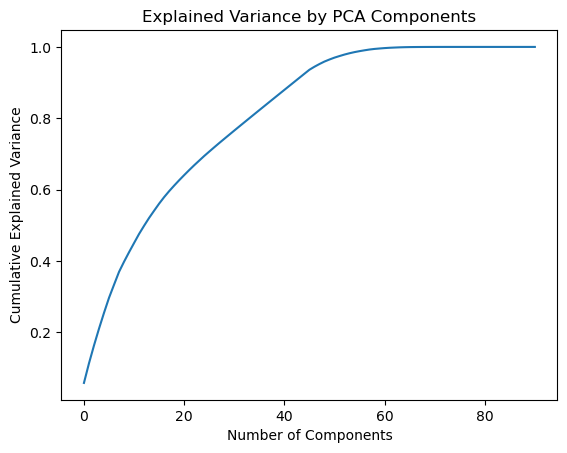

In [29]:

# Perform PCA with a large number of components to analyze variance
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()

In [31]:
# Choose number of components to retain
n_components = 40  # for example
X_pca = X_pca[:, :n_components]

# Define a function to compute DTW distance
def dtw_distance(x, y):
    dist, _ = fastdtw(x, y)
    return dist

# Compute pairwise DTW distances for a subset of data (e.g., first 100 samples)
subset_size = 100
subset_X_pca = X_pca[:subset_size]
distance_matrix = pdist(subset_X_pca, metric=dtw_distance)

# Convert the distance matrix to a squareform
distance_matrix_square = squareform(distance_matrix)

# Print the resulting distance matrix
print(distance_matrix_square)


[[ 0.         42.65034862 43.32417543 ... 53.6201737  60.32042135
  72.94105707]
 [42.65034862  0.          7.52080544 ... 29.01688612 54.37145325
  52.6836351 ]
 [43.32417543  7.52080544  0.         ... 32.10847101 56.09243472
  52.86022003]
 ...
 [53.6201737  29.01688612 32.10847101 ...  0.         52.51405205
  56.52691215]
 [60.32042135 54.37145325 56.09243472 ... 52.51405205  0.
  55.03375059]
 [72.94105707 52.6836351  52.86022003 ... 56.52691215 55.03375059
   0.        ]]


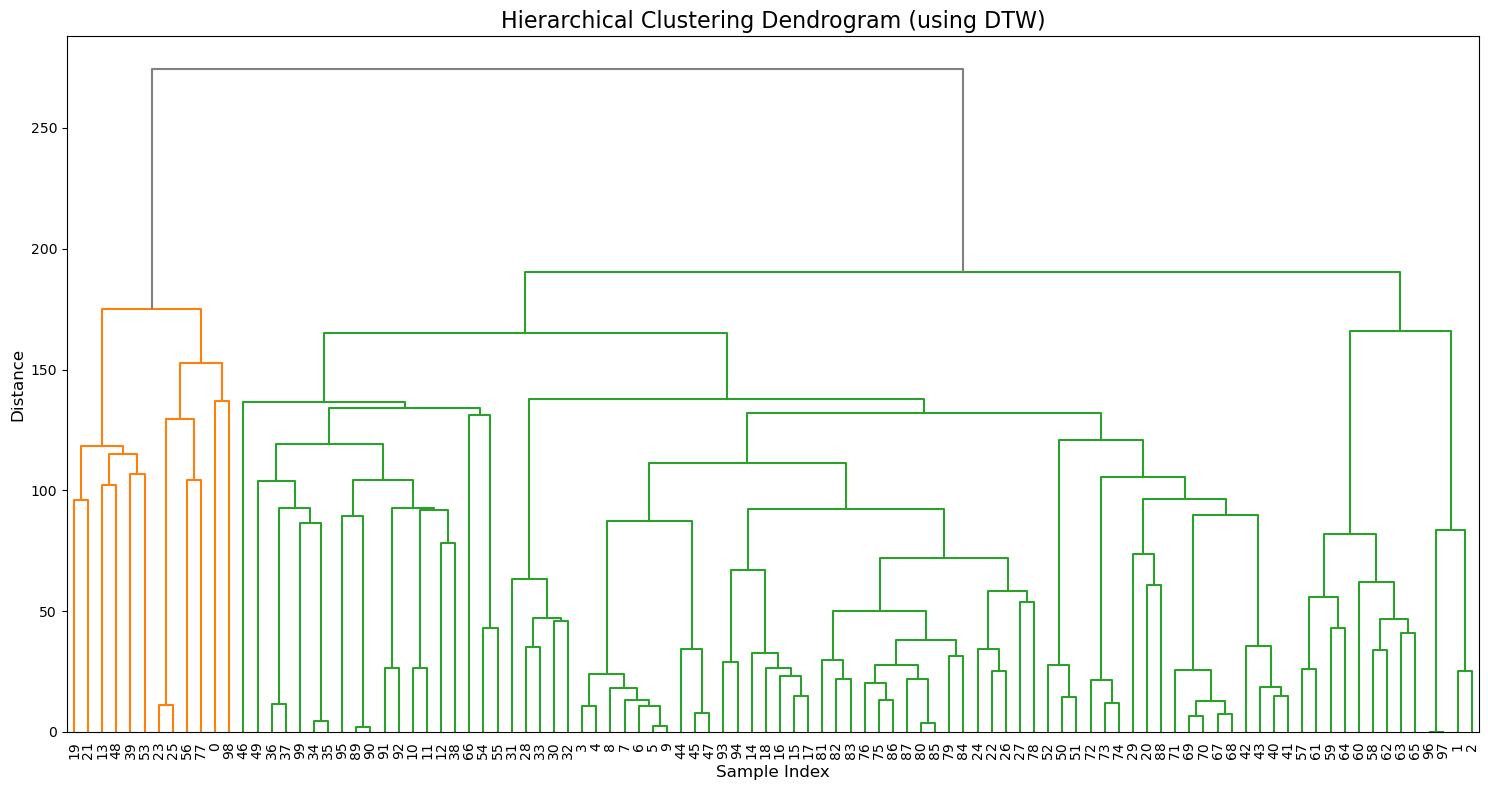

In [37]:
# Perform hierarchical clustering
linkage_matrix = linkage(distance_matrix_square, method='average')

# Plot the dendrogram
plt.figure(figsize=(15, 8))
dendrogram(
    linkage_matrix,
    labels=range(subset_size),  # Use range if no labels in data.index
    leaf_rotation=90,  # Rotate labels for better readability
    leaf_font_size=10,  # Font size for labels
    color_threshold=0.7 * np.max(linkage_matrix[:, 2]),  # Threshold for color clusters
    above_threshold_color='grey'  # Color for clusters above threshold
)

plt.title("Hierarchical Clustering Dendrogram (using DTW)", fontsize=16)
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("Distance", fontsize=12)
#plt.grid(True)
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

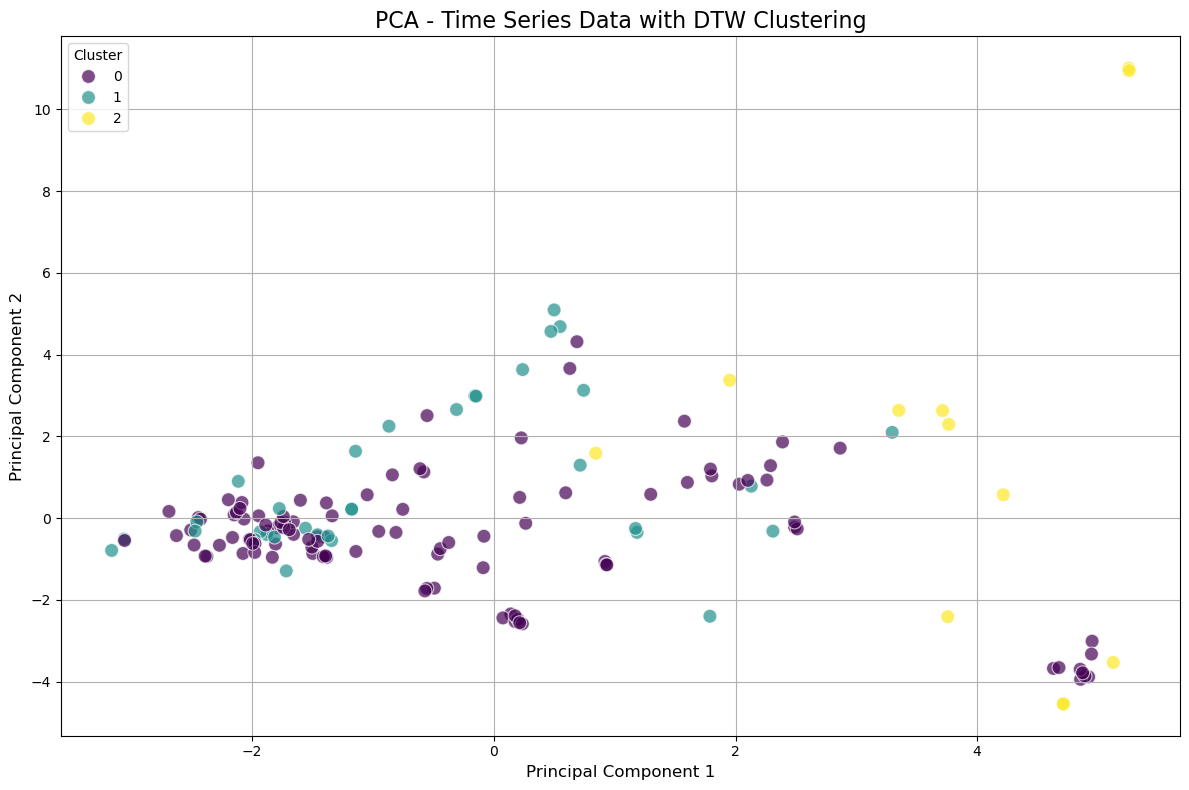

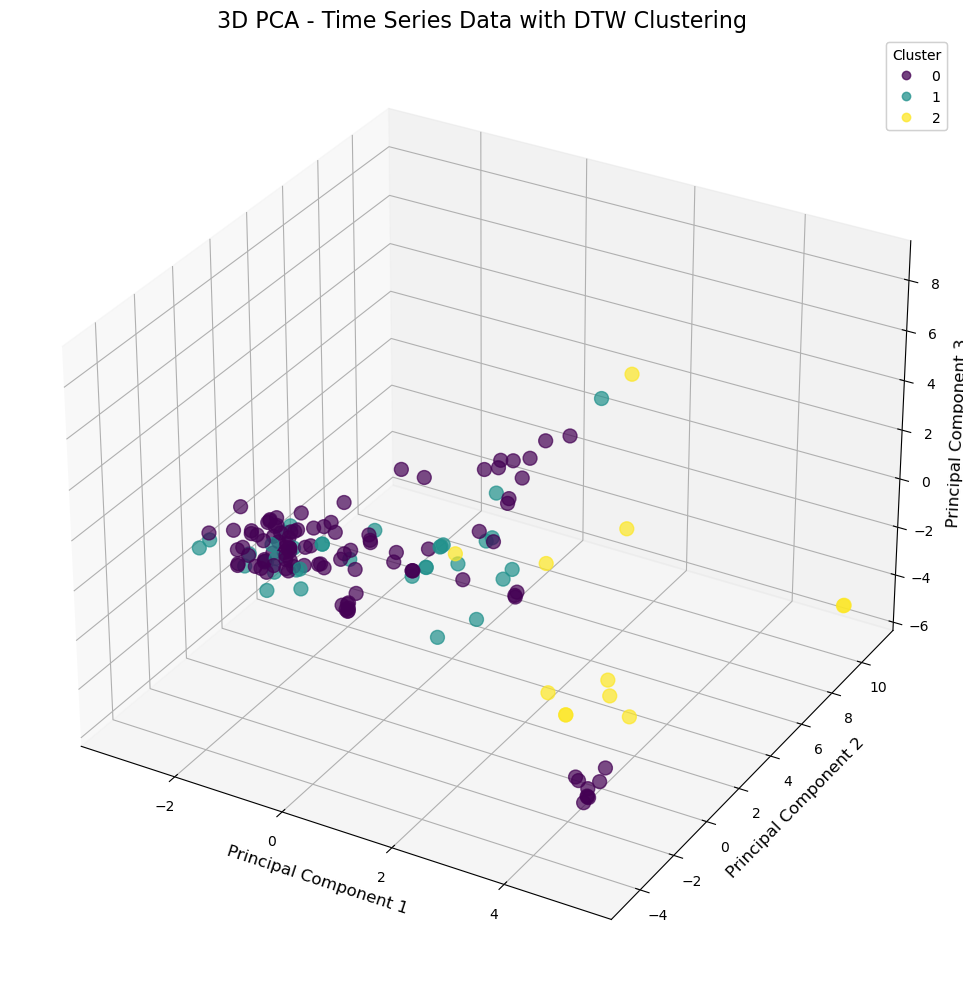

Silhouette Score: 0.13


In [38]:
# Perform clustering with TimeSeriesKMeans
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", random_state=42)
y_kmeans = model.fit_predict(X_scaled)

# Add cluster labels to the PCA DataFrame
pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
pca_df['Cluster'] = y_kmeans

# 2D visualization of the first two principal components
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='viridis', data=pca_df, s=100, alpha=0.7)
plt.title('PCA - Time Series Data with DTW Clustering', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Cluster', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# 3D visualization of the first three principal components
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['Cluster'], cmap='viridis', s=100, alpha=0.7)
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster", fontsize=10)
ax.add_artist(legend1)
ax.set_title('3D PCA - Time Series Data with DTW Clustering', fontsize=16)
ax.set_xlabel('Principal Component 1', fontsize=12)
ax.set_ylabel('Principal Component 2', fontsize=12)
ax.set_zlabel('Principal Component 3', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Silhouette Score to evaluate clustering
silhouette_avg = silhouette_score(X_scaled, y_kmeans)
print(f'Silhouette Score: {silhouette_avg:.2f}')

In [39]:
for n_clusters in range(2, 10):
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
    y_kmeans = model.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, y_kmeans)
    print(f'For n_clusters = {n_clusters}, Silhouette Score = {silhouette_avg:.2f}')


For n_clusters = 2, Silhouette Score = 0.20
For n_clusters = 3, Silhouette Score = 0.13
For n_clusters = 4, Silhouette Score = 0.05
For n_clusters = 5, Silhouette Score = 0.06
For n_clusters = 6, Silhouette Score = 0.06
For n_clusters = 7, Silhouette Score = 0.04
For n_clusters = 8, Silhouette Score = 0.04
For n_clusters = 9, Silhouette Score = 0.00
